# Double Duelling Q Network with Experience Replay

In the previous part we discovered that just being a bit less greedy in our action policy was not enough. It may or may not have helped a bit in some cases, but it certainly didn't solve the problem.

Maybe it's time to look at more sophisticated network topologies. Let's look at what the experts do for some guidance: For me this means this excellent blog post by Arthur Juliani: [Simple Reinforcement Learning with TensorFlow Part 4: Deep Q-Networks and Beyond](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df).

I encourage you to read the article yourself, but here is a summary of what he does there that we currently don't:

* Convolutional Layers
* Experience Replay
* Pre-training games
* Separate Target Network (Double Q Network)
* Duelling Q Network

## Convolutional Layers

[Convolutional network layers](https://en.wikipedia.org/wiki/Convolutional_neural_network) are very powerful for processing and analyzing visual images as they process and identify patterns in stacks of 2D input data arrays - generally different colour bands of 2D raster images. 

Given the inherent 2D nature of a Tic Tac Toe board, this might help quite a lot.

## Experience Replay

By storing previous games in an experience buffer and reuse this past experience when training the network we can increase the stability of the training. We avoid the network getting stuck in patterns where it keeps playing the same bad moves over and over again with little change to outcomes or learning. In particular, my hope is that this will help us in cases where positive experiences are very rare, e.g. playing second against the Min Max Player.

## Pre-training games

This is a set of games where we chose moves completely randomly. This gives us a reasonably broad experience and sample of possible outcomes. If we start directly with a network based move policy we have the risk that random weight initialization creates a policy which is stuck in a local minimum and very unlikely to allow us to explore a wide set of actions - even using a $\epsilon$-greedy strategy.

## Separate Target Network

According to the experts, using the same Q-Network for a training as well as the target Q function for computing the loss can become unstable and spiral out of control. By separating the target into an independent second network,  training should  become more stable.

Our current topology looks like this, with the current state being $s$, the state after move $a$ being $s'$, the reward of the current move being $r$, and the discount value for future expected rewards being $\gamma$:

![Title](./Images/SingleQNet.PNG)

After adding a target network it will look like this:

![Title](./Images/DoubleQNet.PNG)

Every now and then we update the target network by copying the weights from the main network to it.

## Duelling Q Network

Currently the network will produce an absolute quality value for every move. A potential improvement over this approach is to put the value of a move in relation to the value of the current board state. I.e. rather than looking at the absolute Q value of a move we ask how much does a move improve or decrease the value of the current board state. Or in other words: How much better or worse is a move compared to the other possible moves in this state. We call this the *Advantage* of the move. I.e.

$$Q(s,a) = V(s) + A(a)$$

where $Q(s,a)$ is the Q value of move $a$ in state $s$, $V(s)$ is the Q value of state $s$, and $A(a)$ is the Advantage of move $a$.

The Duelling Q Network would look like this:

![Title](./Images/DuellingQNet.PNG)

## Putting it all together
If we wanted to be methodical about this, we should try each of those potential improvements independently and see if and how much they actually improve things. Then all combinations. Nobody has time for that, so we add Experience Replay, Pre Training games, a separate target network, and the Duelling Q Network topology all at once. We don't quite do Convolutional Layers yet, however. The code for this is in [ExpDoubleDuelQPlayer](https://github.com/fcarsten/tic-tac-toe/blob/master/tic_tac_toe/ExpDoubleDuelQPlayer.py).

Let's take it for a spin:

First, the easy case - Going first against the RandomPlayer.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
After 100 game we have draws: 8, Player 1 wins: 64, and Player 2 wins: 28.
Which gives percentages of draws: 8.00%, Player 1 wins: 64.00%, and Player 2 wins:  28.00%
After 100 game we have draws: 13, Player 1 wins: 58, and Player 2 wins: 29.
Which gives percentages of draws: 13.00%, Player 1 wins: 58.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 14, Player 1 wins: 58, and Player 2 wins: 28.
Which gives percentages of draws: 14.00%, Player 1 wins: 58.00%, and Player 2 wins:  28.00%
After 100 game we have draws: 11, Player 1 wins: 66, and Player 2 wins: 23.
Which gives percentages of draws: 11.00%, Player 1 wins: 66.00%, and Player 2 wins:  23.00%
After 100 game we have draws: 7, Player 1 wins: 69, and Player 2 wins: 24.
Which gives percentages of draws: 7.00%, Player 1 wins: 69.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 7, Player 1 wins: 67, and Player 2 wins: 26.
Which gives perc

After 100 game we have draws: 5, Player 1 wins: 91, and Player 2 wins: 4.
Which gives percentages of draws: 5.00%, Player 1 wins: 91.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 8, Player 1 wins: 92, and Player 2 wins: 0.
Which gives percentages of draws: 8.00%, Player 1 wins: 92.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 92, and Player 2 wins: 4.
Which gives percentages of draws: 4.00%, Player 1 wins: 92.00%, and Player 2 wins:  4.00%
After 100 game we have draws: 2, Player 1 wins: 92, and Player 2 wins: 6.
Which gives percentages of draws: 2.00%, Player 1 wins: 92.00%, and Player 2 wins:  6.00%
After 100 game we have draws: 4, Player 1 wins: 89, and Player 2 wins: 7.
Which gives percentages of draws: 4.00%, Player 1 wins: 89.00%, and Player 2 wins:  7.00%
After 100 game we have draws: 3, Player 1 wins: 89, and Player 2 wins: 8.
Which gives percentages of draws: 3.00%, Player 1 wins: 89.00%, and Player 2 wins:  8.00%
After 100 game w

After 100 game we have draws: 6, Player 1 wins: 91, and Player 2 wins: 3.
Which gives percentages of draws: 6.00%, Player 1 wins: 91.00%, and Player 2 wins:  3.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%


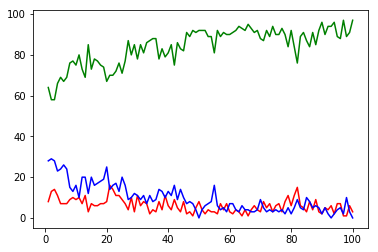

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.TFSessionManager import TFSessionManager
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.ExpDoubleDuelQPlayer import ExpDoubleDuelQPlayer
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent

tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

So far so good. It seems we are indeed doing slightly better than the simple NN from part 4. 

let's try going second against the RandomPlayer:

After 100 game we have draws: 17, Player 1 wins: 58, and Player 2 wins: 25.
Which gives percentages of draws: 17.00%, Player 1 wins: 58.00%, and Player 2 wins:  25.00%
After 100 game we have draws: 9, Player 1 wins: 62, and Player 2 wins: 29.
Which gives percentages of draws: 9.00%, Player 1 wins: 62.00%, and Player 2 wins:  29.00%
After 100 game we have draws: 9, Player 1 wins: 67, and Player 2 wins: 24.
Which gives percentages of draws: 9.00%, Player 1 wins: 67.00%, and Player 2 wins:  24.00%
After 100 game we have draws: 11, Player 1 wins: 70, and Player 2 wins: 19.
Which gives percentages of draws: 11.00%, Player 1 wins: 70.00%, and Player 2 wins:  19.00%
After 100 game we have draws: 14, Player 1 wins: 61, and Player 2 wins: 25.
Which gives percentages of draws: 14.00%, Player 1 wins: 61.00%, and Player 2 wins:  25.00%
After 100 game we have draws: 18, Player 1 wins: 59, and Player 2 wins: 23.
Which gives percentages of draws: 18.00%, Player 1 wins: 59.00%, and Player 2 wins:  23.

After 100 game we have draws: 8, Player 1 wins: 34, and Player 2 wins: 58.
Which gives percentages of draws: 8.00%, Player 1 wins: 34.00%, and Player 2 wins:  58.00%
After 100 game we have draws: 9, Player 1 wins: 25, and Player 2 wins: 66.
Which gives percentages of draws: 9.00%, Player 1 wins: 25.00%, and Player 2 wins:  66.00%
After 100 game we have draws: 10, Player 1 wins: 20, and Player 2 wins: 70.
Which gives percentages of draws: 10.00%, Player 1 wins: 20.00%, and Player 2 wins:  70.00%
After 100 game we have draws: 10, Player 1 wins: 28, and Player 2 wins: 62.
Which gives percentages of draws: 10.00%, Player 1 wins: 28.00%, and Player 2 wins:  62.00%
After 100 game we have draws: 8, Player 1 wins: 30, and Player 2 wins: 62.
Which gives percentages of draws: 8.00%, Player 1 wins: 30.00%, and Player 2 wins:  62.00%
After 100 game we have draws: 9, Player 1 wins: 30, and Player 2 wins: 61.
Which gives percentages of draws: 9.00%, Player 1 wins: 30.00%, and Player 2 wins:  61.00%


After 100 game we have draws: 13, Player 1 wins: 17, and Player 2 wins: 70.
Which gives percentages of draws: 13.00%, Player 1 wins: 17.00%, and Player 2 wins:  70.00%
After 100 game we have draws: 17, Player 1 wins: 14, and Player 2 wins: 69.
Which gives percentages of draws: 17.00%, Player 1 wins: 14.00%, and Player 2 wins:  69.00%
After 100 game we have draws: 20, Player 1 wins: 8, and Player 2 wins: 72.
Which gives percentages of draws: 20.00%, Player 1 wins: 8.00%, and Player 2 wins:  72.00%
After 100 game we have draws: 14, Player 1 wins: 18, and Player 2 wins: 68.
Which gives percentages of draws: 14.00%, Player 1 wins: 18.00%, and Player 2 wins:  68.00%
After 100 game we have draws: 7, Player 1 wins: 10, and Player 2 wins: 83.
Which gives percentages of draws: 7.00%, Player 1 wins: 10.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 18, Player 1 wins: 8, and Player 2 wins: 74.
Which gives percentages of draws: 18.00%, Player 1 wins: 8.00%, and Player 2 wins:  74.00

After 100 game we have draws: 13, Player 1 wins: 8, and Player 2 wins: 79.
Which gives percentages of draws: 13.00%, Player 1 wins: 8.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 10, Player 1 wins: 16, and Player 2 wins: 74.
Which gives percentages of draws: 10.00%, Player 1 wins: 16.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 19, Player 1 wins: 14, and Player 2 wins: 67.
Which gives percentages of draws: 19.00%, Player 1 wins: 14.00%, and Player 2 wins:  67.00%
After 100 game we have draws: 16, Player 1 wins: 13, and Player 2 wins: 71.
Which gives percentages of draws: 16.00%, Player 1 wins: 13.00%, and Player 2 wins:  71.00%
After 100 game we have draws: 18, Player 1 wins: 8, and Player 2 wins: 74.
Which gives percentages of draws: 18.00%, Player 1 wins: 8.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 16, Player 1 wins: 8, and Player 2 wins: 76.
Which gives percentages of draws: 16.00%, Player 1 wins: 8.00%, and Player 2 wins:  76.00

After 100 game we have draws: 13, Player 1 wins: 7, and Player 2 wins: 80.
Which gives percentages of draws: 13.00%, Player 1 wins: 7.00%, and Player 2 wins:  80.00%
After 100 game we have draws: 16, Player 1 wins: 12, and Player 2 wins: 72.
Which gives percentages of draws: 16.00%, Player 1 wins: 12.00%, and Player 2 wins:  72.00%
After 100 game we have draws: 13, Player 1 wins: 6, and Player 2 wins: 81.
Which gives percentages of draws: 13.00%, Player 1 wins: 6.00%, and Player 2 wins:  81.00%
After 100 game we have draws: 15, Player 1 wins: 13, and Player 2 wins: 72.
Which gives percentages of draws: 15.00%, Player 1 wins: 13.00%, and Player 2 wins:  72.00%
After 100 game we have draws: 14, Player 1 wins: 8, and Player 2 wins: 78.
Which gives percentages of draws: 14.00%, Player 1 wins: 8.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 12, Player 1 wins: 7, and Player 2 wins: 81.
Which gives percentages of draws: 12.00%, Player 1 wins: 7.00%, and Player 2 wins:  81.00%


After 100 game we have draws: 19, Player 1 wins: 8, and Player 2 wins: 73.
Which gives percentages of draws: 19.00%, Player 1 wins: 8.00%, and Player 2 wins:  73.00%
After 100 game we have draws: 16, Player 1 wins: 4, and Player 2 wins: 80.
Which gives percentages of draws: 16.00%, Player 1 wins: 4.00%, and Player 2 wins:  80.00%
After 100 game we have draws: 13, Player 1 wins: 10, and Player 2 wins: 77.
Which gives percentages of draws: 13.00%, Player 1 wins: 10.00%, and Player 2 wins:  77.00%
After 100 game we have draws: 20, Player 1 wins: 9, and Player 2 wins: 71.
Which gives percentages of draws: 20.00%, Player 1 wins: 9.00%, and Player 2 wins:  71.00%
After 100 game we have draws: 21, Player 1 wins: 6, and Player 2 wins: 73.
Which gives percentages of draws: 21.00%, Player 1 wins: 6.00%, and Player 2 wins:  73.00%
After 100 game we have draws: 17, Player 1 wins: 3, and Player 2 wins: 80.
Which gives percentages of draws: 17.00%, Player 1 wins: 3.00%, and Player 2 wins:  80.00%
Af

After 100 game we have draws: 16, Player 1 wins: 5, and Player 2 wins: 79.
Which gives percentages of draws: 16.00%, Player 1 wins: 5.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 24, Player 1 wins: 1, and Player 2 wins: 75.
Which gives percentages of draws: 24.00%, Player 1 wins: 1.00%, and Player 2 wins:  75.00%
After 100 game we have draws: 18, Player 1 wins: 5, and Player 2 wins: 77.
Which gives percentages of draws: 18.00%, Player 1 wins: 5.00%, and Player 2 wins:  77.00%
After 100 game we have draws: 21, Player 1 wins: 5, and Player 2 wins: 74.
Which gives percentages of draws: 21.00%, Player 1 wins: 5.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 13, Player 1 wins: 4, and Player 2 wins: 83.
Which gives percentages of draws: 13.00%, Player 1 wins: 4.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 15, Player 1 wins: 4, and Player 2 wins: 81.
Which gives percentages of draws: 15.00%, Player 1 wins: 4.00%, and Player 2 wins:  81.00%
Afte

After 100 game we have draws: 17, Player 1 wins: 5, and Player 2 wins: 78.
Which gives percentages of draws: 17.00%, Player 1 wins: 5.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 9, Player 1 wins: 4, and Player 2 wins: 87.
Which gives percentages of draws: 9.00%, Player 1 wins: 4.00%, and Player 2 wins:  87.00%
After 100 game we have draws: 16, Player 1 wins: 1, and Player 2 wins: 83.
Which gives percentages of draws: 16.00%, Player 1 wins: 1.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 16, Player 1 wins: 4, and Player 2 wins: 80.
Which gives percentages of draws: 16.00%, Player 1 wins: 4.00%, and Player 2 wins:  80.00%
After 100 game we have draws: 18, Player 1 wins: 3, and Player 2 wins: 79.
Which gives percentages of draws: 18.00%, Player 1 wins: 3.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 19, Player 1 wins: 5, and Player 2 wins: 76.
Which gives percentages of draws: 19.00%, Player 1 wins: 5.00%, and Player 2 wins:  76.00%
After 

After 100 game we have draws: 14, Player 1 wins: 7, and Player 2 wins: 79.
Which gives percentages of draws: 14.00%, Player 1 wins: 7.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 16, Player 1 wins: 3, and Player 2 wins: 81.
Which gives percentages of draws: 16.00%, Player 1 wins: 3.00%, and Player 2 wins:  81.00%


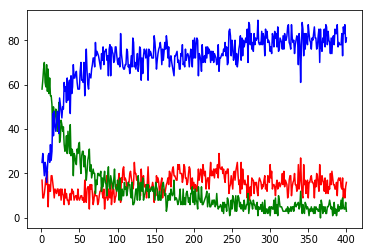

In [4]:
tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer, num_battles = 400)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Not bad either. Definitely an improvement over the simple NN, but still not perfect.

Now for the real stuff - playing against MinMax. Neural Network going first to start off with:

After 100 game we have draws: 16, Player 1 wins: 0, and Player 2 wins: 84.
Which gives percentages of draws: 16.00%, Player 1 wins: 0.00%, and Player 2 wins:  84.00%
After 100 game we have draws: 25, Player 1 wins: 0, and Player 2 wins: 75.
Which gives percentages of draws: 25.00%, Player 1 wins: 0.00%, and Player 2 wins:  75.00%
After 100 game we have draws: 20, Player 1 wins: 0, and Player 2 wins: 80.
Which gives percentages of draws: 20.00%, Player 1 wins: 0.00%, and Player 2 wins:  80.00%
After 100 game we have draws: 17, Player 1 wins: 0, and Player 2 wins: 83.
Which gives percentages of draws: 17.00%, Player 1 wins: 0.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 17, Player 1 wins: 0, and Player 2 wins: 83.
Which gives percentages of draws: 17.00%, Player 1 wins: 0.00%, and Player 2 wins:  83.00%
After 100 game we have draws: 11, Player 1 wins: 0, and Player 2 wins: 89.
Which gives percentages of draws: 11.00%, Player 1 wins: 0.00%, and Player 2 wins:  89.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

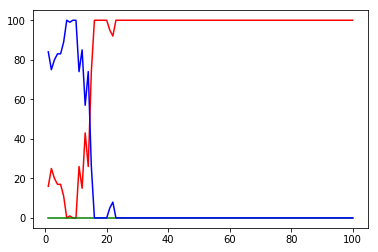

In [5]:
from tic_tac_toe.MinMaxAgent import MinMaxAgent

mm_player = MinMaxAgent()

tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, mm_player)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

This seems to work reasonably well. There seems to be a chance that every now and then for short relapse into losing 100%, but the network seems to be able to recover and get back on track. 

Let's try going second:

After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 0, Player 1 wins: 100, and Player 2 wins: 0.
Which gives percentages of draws: 0.00%, Player 1 wins: 100.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 3, Player 1 wins: 97, and Player 2 wins: 0.
Which gives percentages of draws: 3.00%, Player 1 wins: 97.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

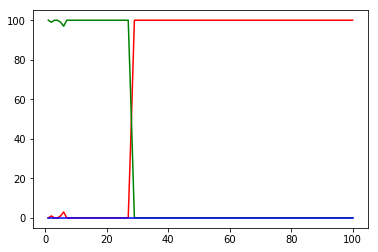

In [6]:
mm_player = MinMaxAgent()

tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(mm_player, nnplayer)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Again, this seems to work reliably now. To be certain would require many more runs, but in the dozen or so runs I did it never failed to achieve 100% draws in the end.

Now let's try our luck against the non-deterministic Min Max player. Again, to start, the Neural Network goes first:


After 100 game we have draws: 18, Player 1 wins: 0, and Player 2 wins: 82.
Which gives percentages of draws: 18.00%, Player 1 wins: 0.00%, and Player 2 wins:  82.00%
After 100 game we have draws: 24, Player 1 wins: 0, and Player 2 wins: 76.
Which gives percentages of draws: 24.00%, Player 1 wins: 0.00%, and Player 2 wins:  76.00%
After 100 game we have draws: 21, Player 1 wins: 0, and Player 2 wins: 79.
Which gives percentages of draws: 21.00%, Player 1 wins: 0.00%, and Player 2 wins:  79.00%
After 100 game we have draws: 26, Player 1 wins: 0, and Player 2 wins: 74.
Which gives percentages of draws: 26.00%, Player 1 wins: 0.00%, and Player 2 wins:  74.00%
After 100 game we have draws: 22, Player 1 wins: 0, and Player 2 wins: 78.
Which gives percentages of draws: 22.00%, Player 1 wins: 0.00%, and Player 2 wins:  78.00%
After 100 game we have draws: 28, Player 1 wins: 0, and Player 2 wins: 72.
Which gives percentages of draws: 28.00%, Player 1 wins: 0.00%, and Player 2 wins:  72.00%
Afte

After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 100, Player 1 wins: 0, and Player 2 wins: 0.
Which gives percentages of draws: 100.00%, Player 1 wins: 0.00%, and Player 2 wins:  0.00%
Afte

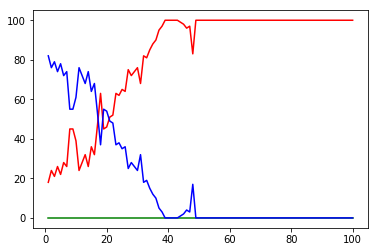

In [7]:
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent
rmm_player = RndMinMaxAgent()

tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rmm_player)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Even this seems to work. No for the final test, going second against the non-deterministic Min Max player:

After 100 game we have draws: 2, Player 1 wins: 98, and Player 2 wins: 0.
Which gives percentages of draws: 2.00%, Player 1 wins: 98.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 6, Player 1 wins: 94, and Player 2 wins: 0.
Which gives percentages of draws: 6.00%, Player 1 wins: 94.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 1, Player 1 wins: 99, and Player 2 wins: 0.
Which gives percentages of draws: 1.00%, Player 1 wins: 99.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 4, Player 1 wins: 96, and Player 2 wins: 0.
Which gives percentages of draws: 4.00%, Player 1 wins: 96.00%, and Player 2 wins:  0.00%
After 100 game w

After 100 game we have draws: 86, Player 1 wins: 14, and Player 2 wins: 0.
Which gives percentages of draws: 86.00%, Player 1 wins: 14.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 84, Player 1 wins: 16, and Player 2 wins: 0.
Which gives percentages of draws: 84.00%, Player 1 wins: 16.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 83, Player 1 wins: 17, and Player 2 wins: 0.
Which gives percentages of draws: 83.00%, Player 1 wins: 17.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 85, Player 1 wins: 15, and Player 2 wins: 0.
Which gives percentages of draws: 85.00%, Player 1 wins: 15.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 10

After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 96, Player 1 wins: 4, and Player 2 wins: 0.
Which gives percentages of draws: 96.00%, Player 1 wins: 4.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 87, Player 1 wins: 13, and Player 2 wins: 0.
Which gives percentages of draws: 87.00%, Player 1 wins: 13.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 96, Player 1 wins: 4, and Player 2 wins: 0.
Which gives percentages of draws: 96.00%, Player 1 wins: 4.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 96, Player 1 wins: 4, and Player 2 wins: 0.
Which gives percentages of draws: 96.00%, Player 1 wins: 4.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 84, Player 1 wins: 16, and Player 2 wins: 0.
Which gives percentages of draws: 84.00%, Player 1 wins: 16.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 87, Player 1 wins: 13, and Player 2 wins: 0.
Which gives percentages of draws: 87.00%, Player 1 wins: 13.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 87, Player 1 wins: 13, and Player 2 wins: 0.
Which gives percentages of draws: 87.00%, Player 1 wins: 13.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 83, Player 1 wins: 17, and Player 2 wins: 0.
Which gives percentages of draws: 83.00%, Player 1 wins: 17.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 85, Player 1 wins: 15, and Player 2 wins: 0.
Which gives percentages of draws: 85.00%, Player 1 wins: 15.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 86, Player 1 wins: 14, and Player 2 wins: 0.
Which gives percentages of draws: 86.00%, Player 1 wins: 14.00%, and Player 2 wins:  0.00%
Afte

After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 86, Player 1 wins: 14, and Player 2 wins: 0.
Which gives percentages of draws: 86.00%, Player 1 wins: 14.00%, and Player 2 wins:  0.00%
After 10

After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 84, Player 1 wins: 16, and Player 2 wins: 0.
Which gives percentages of draws: 84.00%, Player 1 wins: 16.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 97, Player 1 wins: 3, and Player 2 wins: 0.
Which gives percentages of draws: 97.00%, Player 1 wins: 3.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 96, Player 1 wins: 4, and Player 2 wins: 0.
Which gives percentages of draws: 96.00%, Player 1 wins: 4.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 85, Player 1 wins: 15, and Player 2 wins: 0.
Which gives percentages of draws: 85.00%, Player 1 wins: 15.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 86, Player 1 wins: 14, and Player 2 wins: 0.
Which gives percentages of draws: 86.00%, Player 1 wins: 14.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 87, Player 1 wins: 13, and Player 2 wins: 0.
Which gives percentages of draws: 87.00%, Player 1 wins: 13.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 97, Player 1 wins: 3, and Player 2 wins: 0.
Which gives percentages of draws: 97.00%, Player 1 wins: 3.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 83, Player 1 wins: 17, and Player 2 wins: 0.
Which gives percentages of draws: 83.00%, Player 1 wins: 17.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 

After 100 game we have draws: 85, Player 1 wins: 15, and Player 2 wins: 0.
Which gives percentages of draws: 85.00%, Player 1 wins: 15.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 ga

After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game

After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 96, Player 1 wins: 4, and Player 2 wins: 0.
Which gives percentages of draws: 96.00%, Player 1 wins: 4.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game

After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 97, Player 1 wins: 3, and Player 2 wins: 0.
Which gives percentages of draws: 97.00%, Player 1 wins: 3.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game w

After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 95, Player 1 wins: 5, and Player 2 wins: 0.
Which gives percentages of draws: 95.00%, Player 1 wins: 5.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 91, Player 1 wins: 9, and Player 2 wins: 0.
Which gives percentages of draws: 91.00%, Player 1 wins: 9.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 90, Player 1 wins: 10, and Player 2 wins: 0.
Which gives percentages of draws: 90.00%, Player 1 wins: 10.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 86, Player 1 wins: 14, and Player 2 wins: 0.
Which gives percentages of draws: 86.00%, Player 1 wins: 14.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 92, Player 1 wins: 8, and Player 2 wins: 0.
Which gives percentages of draws: 92.00%, Player 1 wins: 8.00%, and Player 2 wins:  0.00%
After 100 

After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 93, Player 1 wins: 7, and Player 2 wins: 0.
Which gives percentages of draws: 93.00%, Player 1 wins: 7.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 88, Player 1 wins: 12, and Player 2 wins: 0.
Which gives percentages of draws: 88.00%, Player 1 wins: 12.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 89, Player 1 wins: 11, and Player 2 wins: 0.
Which gives percentages of draws: 89.00%, Player 1 wins: 11.00%, and Player 2 wins:  0.00%
After 100 game we have draws: 94, Player 1 wins: 6, and Player 2 wins: 0.
Which gives percentages of draws: 94.00%, Player 1 wins: 6.00%, and Player 2 wins:  0.00%
After 100 

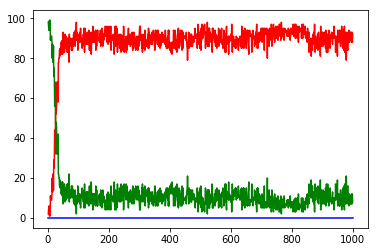

In [8]:
rmm_player = RndMinMaxAgent()

tf.reset_default_graph()

nnplayer = ExpDoubleDuelQPlayer("QLearner1")

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rmm_player, nnplayer, num_battles = 1000)

p = plt.plot(game_number, draws, 'r-', game_number, p1_wins, 'g-', game_number, p2_wins, 'b-')

plt.show()
TFSessionManager.set_session(None)

Better than before, but still not perfect. I seems to get something around 80 +/- 15 % draws in the end. Not the 100% we were looking for.

To summarize:

| Player | NN Player 1st | NN Player 2nd |
| --- | --- | --- |
| Random | Better again, still not perfect    | Better, still losing some |
| Min Max | Seems to work    | Seems to work  |
| Rnd Min Max | Seems to work | Better, but not perfect |

In the next part we add Convolutional network layers and see if this helps us getting the last few missing percent.